In [8]:
%matplotlib inline

# Imports
import gc
import matplotlib.pyplot as plt
import os
import statsmodels.stats.proportion

# seaborn
import seaborn
seaborn.set()
seaborn.set_style("darkgrid")

import sklearn.linear_model
import sklearn.pipeline

# Project imports
from legacy_model import *

In [2]:
# Get raw data
raw_data = get_raw_scdb_data("../data/input/SCDB_Legacy_01_justiceCentered_Citation.csv")

# Get feature data
if os.path.exists("../data/output/feature_data.hdf.gz"):
    print("Loading from HDF5 cache")
    feature_df = pandas.read_hdf("../data/output/feature_data.hdf.gz", "root")
else:
    # Process
    feature_df = preprocess_raw_data(raw_data, include_direction=True)
    
    # Write out feature datas
    feature_df.to_hdf("../data/output/feature_data.hdf.gz", "root", complevel=6, complib="zlib")

Loading from HDF5 cache


In [3]:
# Downsample to float
feature_df = feature_df.astype(numpy.float16)

In [4]:
# Remove term
nonterm_features = [f for f in feature_df.columns if not f.startswith("term_")]
original_feature_df = feature_df.copy()
feature_df = original_feature_df.loc[:, nonterm_features].copy()
gc.collect()

1928

In [5]:
# Output some diagnostics on features
print(raw_data.shape)
print(feature_df.shape)
assert(raw_data.shape[0] == feature_df.shape[0])

(249793, 64)
(249793, 1501)


In [6]:
# Output basic quantities for sample
print(pandas.DataFrame(raw_data["justice_outcome_disposition"].value_counts()))
print(pandas.DataFrame(raw_data["justice_outcome_disposition"].value_counts(normalize=True)))

    justice_outcome_disposition
 0                       114780
 1                        94505
-1                        40508
    justice_outcome_disposition
 0                     0.459500
 1                     0.378333
-1                     0.162166


In [ ]:
# Reset output file timestamp per run
file_timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")

# Reset seed per run
numpy.random.seed(0)

# Setup training time period
dummy_window = 10
min_training_years = 50
term_range = range(raw_data["term"].min() + min_training_years,
                   raw_data["term"].max()+1)

# Number of years between "forest fires"
reset_interval = 9999

# Setup model
m = None
term_count = 0
feature_importance_df = pandas.DataFrame()

for term in term_range:
    # Diagnostic output
    print("Term: {0}".format(term))
    term_count += 1
    
    # Setup train and test periods
    train_index = (raw_data.loc[:, "term"] < term).values
    dummy_train_index = ((raw_data.loc[:, "term"] < term) & (raw_data.loc[:, "term"] >= (term-dummy_window))).values
    test_index = (raw_data.loc[:, "term"] == term).values
    
    # Setup train data
    feature_data_train = feature_df.loc[train_index, :]
    target_data_train = (raw_data.loc[train_index, "justice_outcome_disposition"]).astype(int)

    # Setup test data
    feature_data_test = feature_df.loc[test_index, :]
    target_data_test = (raw_data.loc[test_index, "justice_outcome_disposition"]).astype(int)
        
    # Check if we should rebuild the model based on changing natural court
    logistic = sklearn.linear_model.LogisticRegressionCV()
    
    # Fit the forest model
    logistic.fit(feature_data_train,
          target_data_train)
    
    # Fit the "dummy" model
    d = sklearn.dummy.DummyClassifier(strategy="most_frequent")
    d.fit(feature_df.loc[dummy_train_index, :],
          (raw_data.loc[dummy_train_index, "justice_outcome_disposition"]).astype(int))
    
    # Perform forest predictions
    raw_data.loc[test_index, "rf_predicted"] = logistic.predict(feature_data_test)
    
    # Store scores per class
    scores = logistic.predict_proba(feature_data_test)
    raw_data.loc[test_index, "rf_predicted_score_other"] = scores[:, 0]
    raw_data.loc[test_index, "rf_predicted_score_affirm"] = scores[:, 1]
    raw_data.loc[test_index, "rf_predicted_score_reverse"] = scores[:, 2]
    
    # Store dummy predictions
    raw_data.loc[test_index, "dummy_predicted"] = d.predict(feature_data_test)
    
    #  Clear
    del feature_data_train
    del feature_data_test
    del target_data_train
    del target_data_test
    gc.collect()

Term: 1841


In [11]:
# Evaluation range
evaluation_index = raw_data.loc[:, "term"].isin(term_range)
target_actual = (raw_data.loc[evaluation_index, "justice_outcome_disposition"]).astype(int)
target_predicted = raw_data.loc[evaluation_index, "rf_predicted"].astype(int)
target_dummy = raw_data.loc[evaluation_index, "dummy_predicted"].astype(int)
raw_data.loc[:, "rf_correct"] = numpy.nan
raw_data.loc[:, "dummy_correct"] = numpy.nan
raw_data.loc[evaluation_index, "rf_correct"] = (target_actual == target_predicted).astype(float)
raw_data.loc[evaluation_index, "dummy_correct"] = (target_actual == target_dummy).astype(float)

# Compare model
print("RF model")
print("="*32)
print(sklearn.metrics.classification_report(target_actual, target_predicted))
print(sklearn.metrics.confusion_matrix(target_actual, target_predicted))
print(sklearn.metrics.accuracy_score(target_actual, target_predicted))
print("="*32)
print("")

# Dummy model
print("Dummy model")
print("="*32)
print(sklearn.metrics.classification_report(target_actual, target_dummy))
print(sklearn.metrics.confusion_matrix(target_actual, target_dummy))
print(sklearn.metrics.accuracy_score(target_actual, target_dummy))
print("="*32)
print("")

RF model
             precision    recall  f1-score   support

         -1       0.78      0.58      0.67     37465
          0       0.59      0.75      0.66    110640
          1       0.60      0.46      0.52     91381

avg / total       0.62      0.62      0.61    239486

[[21906 11229  4330]
 [ 3702 83256 23682]
 [ 2534 46459 42388]]
0.616111171425

Dummy model
             precision    recall  f1-score   support

         -1       0.33      0.01      0.03     37465
          0       0.52      0.76      0.62    110640
          1       0.57      0.47      0.52     91381

avg / total       0.51      0.53      0.49    239486

[[  495 29856  7114]
 [  618 84076 25946]
 [  398 47700 43283]]
0.533868368088



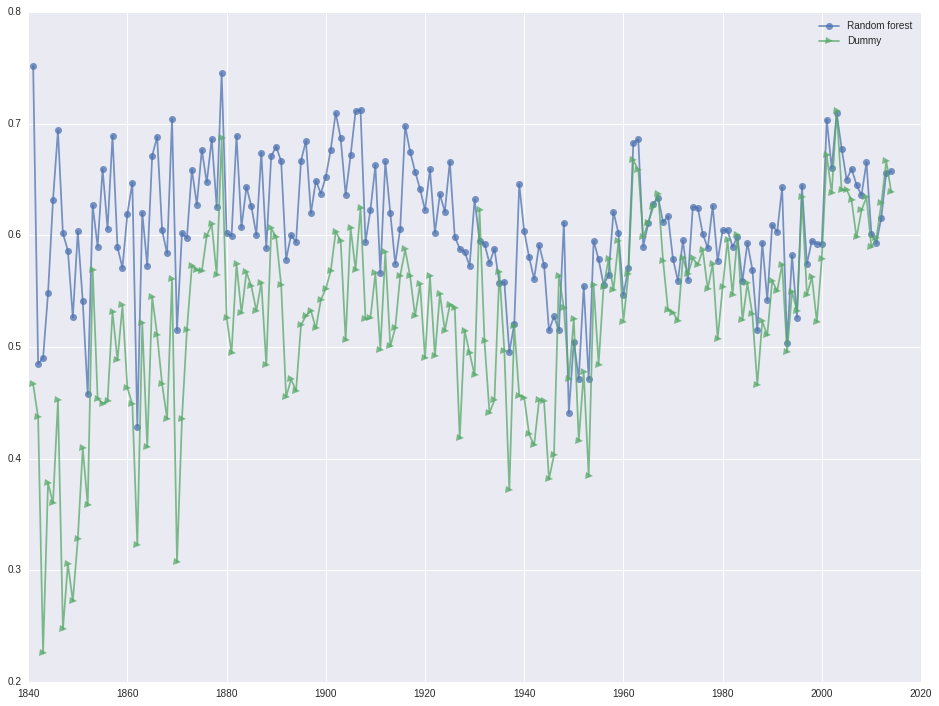

In [12]:
# Setup time series
rf_correct_ts = raw_data.loc[evaluation_index, :].groupby("term")["rf_correct"].mean()
dummy_correct_ts = raw_data.loc[evaluation_index, :].groupby("term")["dummy_correct"].mean()

# Plot all accuracies
f = plt.figure(figsize=(16, 12))
plt.plot(rf_correct_ts.index, rf_correct_ts,
         marker='o', alpha=0.75)
plt.plot(dummy_correct_ts.index, dummy_correct_ts,
         marker='>', alpha=0.75)
plt.legend(('Random forest', 'Dummy'))

In [ ]:
# Setup time series
rf_spread_ts = rf_correct_ts - dummy_correct_ts

# Plot all accuracies
f = plt.figure(figsize=(16, 12))
plt.bar(rf_spread_ts.index, rf_spread_ts,
        alpha=0.75)
plt.xlabel("Term")
plt.ylabel("Spread (%)")
plt.title("Spread over dummy model for justice accuracy")

In [ ]:
# Feature importance
last_feature_importance_df = pandas.DataFrame(list(zip(feature_df.columns, m.feature_importances_)),
                                         columns=["feature", "importance"])
last_feature_importance_df.sort_values(["importance"], ascending=False).head(10)

In [ ]:
# Output stats
print("t-test:")
print("Uncalibrated:")
print(scipy.stats.ttest_rel(rf_correct_ts.values,
                   dummy_correct_ts.values))

print("=" * 16)
print("ranksum-test:")
print("Uncalibrated:")
print(scipy.stats.ranksums(rf_correct_ts.values,
                   dummy_correct_ts.values))

print("=" * 16)
print("Binomial:")
print(statsmodels.stats.proportion.binom_test(raw_data.loc[evaluation_index, "rf_correct"].sum(),
                                              raw_data.loc[evaluation_index, "rf_correct"].shape[0],
                                              raw_data.loc[evaluation_index, "dummy_correct"].mean(),
                                              alternative="larger"))

In [ ]:
# Get case-level prediction
#scdb_data.loc[evaluation_index, "rf_predicted_case"] = 
rf_predicted_case = pandas.DataFrame(raw_data.loc[evaluation_index, :]\
    .groupby(["docketId"])["rf_predicted"]\
    .agg(lambda x: x.value_counts().index[0]))
rf_predicted_case.columns = ["rf_predicted_case"]

dummy_predicted_case = pandas.DataFrame(raw_data.loc[evaluation_index, :]\
    .groupby(["docketId"])["dummy_predicted"]\
    .agg(lambda x: x.value_counts().index[0]))
dummy_predicted_case.columns = ["dummy_predicted_case"]

# Set DFs
rf_predicted_case = raw_data[["docketId", "case_outcome_disposition", "rf_predicted"]].join(rf_predicted_case, on="docketId")
dumy_predicted_case = raw_data[["docketId", "dummy_predicted"]].join(dummy_predicted_case, on="docketId")

raw_data.loc[:, "rf_predicted_case"] = rf_predicted_case
raw_data.loc[:, "dummy_predicted_case"] = dumy_predicted_case

In [ ]:
# Output case distribution
case_outcomes = raw_data.groupby(["docketId"])["case_outcome_disposition"].apply(lambda x: x.mode())
case_outcomes = case_outcomes.apply(lambda x: int(x) if type(x) in [numpy.float64] else None)
case_outcomes  = (case_outcomes).astype(int)
print(case_outcomes.value_counts())
print(case_outcomes.value_counts(normalize=True))

In [ ]:
# Output comparison
# Evaluation range
evaluation_index = raw_data.loc[:, "term"].isin(term_range) & -raw_data.loc[:, "case_outcome_disposition"].isnull()
target_actual = (raw_data.loc[evaluation_index, "case_outcome_disposition"] > 0).astype(int)
target_predicted = (raw_data.loc[evaluation_index, "rf_predicted_case"] > 0).astype(int)
target_dummy = (raw_data.loc[evaluation_index, "dummy_predicted_case"] > 0).astype(int)

raw_data.loc[:, "rf_correct_case"] = numpy.nan
raw_data.loc[:, "dummy_correct_case"] = numpy.nan
raw_data.loc[evaluation_index, "rf_correct_case"] = (target_actual == target_predicted).astype(float)
raw_data.loc[evaluation_index, "dummy_correct_case"] = (target_actual == target_dummy).astype(float)

# Compare model
print("RF model")
print("="*32)
print(sklearn.metrics.classification_report(target_actual, target_predicted))
print(sklearn.metrics.confusion_matrix(target_actual, target_predicted))
print(sklearn.metrics.accuracy_score(target_actual, target_predicted))
print("="*32)
print("")

# Dummy model
print("Dummy model")
print("="*32)
print(sklearn.metrics.classification_report(target_actual, target_dummy))
print(sklearn.metrics.confusion_matrix(target_actual, target_dummy))
print(sklearn.metrics.accuracy_score(target_actual, target_dummy))
print("="*32)
print("")

In [ ]:
# Setup time series
rf_correct_case_ts = raw_data.loc[evaluation_index, :].groupby("term")["rf_correct_case"].mean()
dummy_correct_case_ts = raw_data.loc[evaluation_index, :].groupby("term")["dummy_correct_case"].mean()

# Plot all accuracies
f = plt.figure(figsize=(16, 12))
plt.plot(rf_correct_case_ts.index, rf_correct_case_ts,
         marker='o', alpha=0.75)
plt.plot(dummy_correct_case_ts.index, dummy_correct_case_ts,
         marker='>', alpha=0.75)
plt.legend(('Random forest', 'Dummy'))

In [ ]:
# Setup time series
rf_spread_case_ts = rf_correct_case_ts - dummy_correct_case_ts

# Plot all accuracies
f = plt.figure(figsize=(16, 12))
plt.bar(rf_spread_case_ts.index, rf_spread_case_ts,
        alpha=0.75)
plt.xlabel("Term")
plt.ylabel("Spread (%)")
plt.title("Spread over dummy model for case accuracy")

In [ ]:
# Setup time series
rf_spread_case_dir_ts = pandas.expanding_sum(numpy.sign(rf_spread_case_ts))

# Plot all accuracies
f = plt.figure(figsize=(16, 12))
plt.plot(rf_spread_case_dir_ts.index, rf_spread_case_dir_ts,
        alpha=0.75)

In [ ]:
# Output stats
print("t-test:")
print("Uncalibrated:")
print(scipy.stats.ttest_rel(rf_correct_case_ts.values,
                   dummy_correct_case_ts.values))

print("=" * 16)
print("ranksum-test:")
print("Uncalibrated:")
print(scipy.stats.ranksums(rf_correct_case_ts.values,
                   dummy_correct_case_ts.values))

print("=" * 16)
print("Binomial:")
case_accuracy_data = raw_data.loc[evaluation_index, ["docketId", "rf_correct_case", "dummy_correct_case"]].drop_duplicates()
print(statsmodels.stats.proportion.binom_test(case_accuracy_data["rf_correct_case"].sum(),
                                              case_accuracy_data["rf_correct_case"].shape[0],
                                              case_accuracy_data["dummy_correct_case"].mean(),
                                              alternative="larger"))

In [ ]:
raw_data.loc[raw_data.loc[:, "caseName"] == "MIRANDA v. ARIZONA", 
              ["caseName", "justiceName", "case_outcome_disposition", "justice_outcome_disposition",
              "rf_predicted", "rf_predicted_score_affirm", "rf_predicted_score_reverse", "rf_correct_case", "dummy_correct_case"]].T

In [ ]:
# Output file data
raw_data.to_csv("../data/output/scdb_legacy_raw_data_most_frequent_trailing_logistic_{0}.csv".format(file_timestamp))
case_accuracy_data.to_csv("../data/output/scdb_legacy_case_data_most_frequent_trailing_logistic_{0}.csv".format(file_timestamp))
feature_importance_df.to_csv("../data/output/scdb_legacy_last_features_most_frequent_trailing_logistic_{0}.csv".format(file_timestamp))

In [ ]:
# Setup feature importance TS
feature_importance_ts = feature_importance_df.groupby(["term", "feature"])["importance"].mean().unstack()
feature_importance_ts.to_csv("../data/output/scdb_legacy_feature_weight_ts_most_frequent_trailing_logistic_{0}.csv".format(file_timestamp))

## Justice Vote Confusion Matrix

In [ ]:
# Evaluation range
evaluation_index = raw_data.loc[:, "term"].isin(term_range)
target_actual = (raw_data.loc[evaluation_index, "justice_outcome_disposition"]).astype(int)
target_predicted = raw_data.loc[evaluation_index, "rf_predicted"].astype(int)
target_dummy = raw_data.loc[evaluation_index, "dummy_predicted"].astype(int)
raw_data.loc[:, "rf_correct"] = numpy.nan
raw_data.loc[:, "dummy_correct"] = numpy.nan
raw_data.loc[evaluation_index, "rf_correct"] = (target_actual == target_predicted).astype(float)
raw_data.loc[evaluation_index, "dummy_correct"] = (target_actual == target_dummy).astype(float)

# Compare model
print("RF model")
print("="*32)
justice_confusion_df = pandas.DataFrame(sklearn.metrics.confusion_matrix(target_actual, target_predicted), columns=["Other", "Affirm", "Reverse"], index=["Other", "Affirm", "Reverse"])
justice_confusion_df

In [ ]:
print(justice_confusion_df.to_latex())

## Case Vote Confusion Matrix

In [ ]:
# Output comparison
# Evaluation range
evaluation_index = raw_data.loc[:, "term"].isin(term_range) & -raw_data.loc[:, "case_outcome_disposition"].isnull()
target_actual = (raw_data.loc[evaluation_index, "case_outcome_disposition"] > 0).astype(int)
target_predicted = (raw_data.loc[evaluation_index, "rf_predicted_case"] > 0).astype(int)
target_dummy = (raw_data.loc[evaluation_index, "dummy_predicted_case"] > 0).astype(int)

raw_data.loc[:, "rf_correct_case"] = numpy.nan
raw_data.loc[:, "dummy_correct_case"] = numpy.nan
raw_data.loc[evaluation_index, "rf_correct_case"] = (target_actual == target_predicted).astype(float)
raw_data.loc[evaluation_index, "dummy_correct_case"] = (target_actual == target_dummy).astype(float)

# Compare model
print("RF model")
print("="*32)
case_confusion_df = pandas.DataFrame(sklearn.metrics.confusion_matrix(target_actual, target_predicted), columns=["Affirm", "Reverse"], index=["Affirm", "Reverse"])
case_confusion_df

In [ ]:
print(case_confusion_df.to_latex())

## Justice Vote Performance against Base Model

In [ ]:
# Output stats
print("t-test:")
print("Uncalibrated:")
print(scipy.stats.ttest_rel(rf_correct_case_ts.values,
                   dummy_correct_case_ts.values))

print("=" * 16)
print("ranksum-test:")
print("Uncalibrated:")
print(scipy.stats.ranksums(rf_correct_case_ts.values,
                   dummy_correct_case_ts.values))

print("=" * 16)
print("Binomial:")
case_accuracy_data = raw_data.loc[evaluation_index, ["docketId", "rf_correct_case", "dummy_correct_case"]].drop_duplicates()
print(statsmodels.stats.proportion.binom_test(case_accuracy_data["rf_correct_case"].sum(),
                                              case_accuracy_data["rf_correct_case"].shape[0],
                                              case_accuracy_data["dummy_correct_case"].mean(),
                                              alternative="larger"))

## Case Vote Performance against Base Model

In [ ]:
# Output stats
print("t-test:")
print("Uncalibrated:")
print(scipy.stats.ttest_rel(rf_correct_case_ts.values,
                   dummy_correct_case_ts.values))

print("=" * 16)
print("ranksum-test:")
print("Uncalibrated:")
print(scipy.stats.ranksums(rf_correct_case_ts.values,
                   dummy_correct_case_ts.values))

print("=" * 16)
print("Binomial:")
case_accuracy_data = raw_data.loc[evaluation_index, ["docketId", "rf_correct_case", "dummy_correct_case"]].drop_duplicates()
print(statsmodels.stats.proportion.binom_test(case_accuracy_data["rf_correct_case"].sum(),
                                              case_accuracy_data["rf_correct_case"].shape[0],
                                              case_accuracy_data["dummy_correct_case"].mean(),
                                              alternative="larger"))

## Feature Weights

In [ ]:
# Get last step weights
num_feature_rows = 3
num_feature_cols = 3
num_feature_total = num_feature_rows * num_feature_cols
last_step = feature_importance_ts.tail(1).T
last_step_top_features = last_step.sort_values(last_step.columns[0], ascending=False).head(num_feature_total).index.tolist()

# Get axis data
min_term = feature_importance_df["term"].min()
max_term = feature_importance_df["term"].max()
min_val = feature_importance_df["importance"].min()
max_val = feature_importance_df["importance"].max()

# Setup grid
#f = plt.figure(figsize=(16, 16))
f, ax = plt.subplots(num_feature_rows, num_feature_cols, figsize=(16,16))

for i in range(len(last_step_top_features)):
    # Get iteration indices
    row_id = int(i / num_feature_cols)
    col_id = (i % num_feature_cols)
    feature_name = last_step_top_features[i]
    
    # Setup title and data
    ax[row_id, col_id].set_title("{0}".format(feature_name), fontsize=10)
    ts_data = feature_importance_ts.loc[:, feature_name]
    
    # Plot fill and marker
    ax[row_id, col_id].fill_between(ts_data.index, 0, ts_data, alpha=0.25, color="green")
    ax[row_id, col_id].plot(ts_data.index, ts_data, marker="o", markersize=3, linewidth=2, color="#898989", alpha=0.75)
    
    # Setup axes
    ax[row_id, col_id].set_xlim(min_term, max_term)
    ax[row_id, col_id].set_xticks(numpy.arange(min_term, max_term, 10))
    ax[row_id, col_id].set_xticklabels(map(str, numpy.arange(min_term, max_term, 10)), rotation=90)
    ax[row_id, col_id].set_ylim(min_val, max_val)
    ax[row_id, col_id].set_yticks(numpy.round(numpy.linspace(min_val, max_val, 4), 3))

# Save as PNG, PDF, and SVG
plt.savefig("../figures/figure_feature_importance_ts_trailing_{0}.png".format(file_timestamp))
plt.savefig("../figures/figure_feature_importance_ts_trailing_{0}.pdf".format(file_timestamp))
plt.savefig("../figures/figure_feature_importance_ts_trailing_{0}.svg".format(file_timestamp))

In [ ]:
# Setup colormap for all positive-negative heatmaps
red_green_cmap = seaborn.diverging_palette(h_neg=10, h_pos=135, as_cmap=True)

In [ ]:
# Top features
num_feature_total = 20
last_step = feature_importance_ts.tail(1).T
last_step_top_features = last_step.sort_values(last_step.columns[0], ascending=False).head(num_feature_total).index.tolist()

# Get axis data
min_term = feature_importance_df["term"].min()
max_term = feature_importance_df["term"].max()
min_val = feature_importance_df["importance"].min()
max_val = feature_importance_df["importance"].max()

# Heatmap
f = plt.figure(figsize=((max_term - min_term) / 4, num_feature_total / 4))
seaborn.heatmap(feature_importance_ts.loc[:, last_step_top_features].T, vmin=0, vmax=max_val, cmap=red_green_cmap)
plt.xlabel("Term")
plt.ylabel("Feature")

# Save as PNG, PDF, and SVG
plt.savefig("../figures/figure_feature_importance_heatmap_trailing_{0}.png".format(file_timestamp))
plt.savefig("../figures/figure_feature_importance_heatmap_trailing_{0}.pdf".format(file_timestamp))
plt.savefig("../figures/figure_feature_importance_heatmap_trailing_{0}.svg".format(file_timestamp))

## Justice Accuracy Heatmap

In [ ]:
# Setup grouping over evaluation index
evaluation_index = raw_data.loc[:, "term"].isin(term_range) & -raw_data.loc[:, "case_outcome_disposition"].isnull()
justice_order = raw_data.loc[evaluation_index, :].groupby(["justiceName"])["term"].min().sort_values().index.tolist()
justice_accuracy_ts = raw_data.loc[evaluation_index, :].groupby(["term", "justiceName"])["rf_correct"].mean().unstack() - \
    raw_data.loc[evaluation_index, :].groupby(["term", "justiceName"])["dummy_correct"].mean().unstack()
min_term = min(justice_accuracy_ts.index)
max_term = max(justice_accuracy_ts.index)
    
# Setup plot
num_justices = justice_accuracy_ts.shape[1]
num_years = justice_accuracy_ts.shape[0]
f, ax = plt.subplots(figsize=(num_years / 4, num_justices / 5))
seaborn.heatmap(justice_accuracy_ts.loc[:, justice_order].T, vmin=-0.5, vmax=0.5, ax=ax, cmap=red_green_cmap)

# Setup labels
_ = ax.set_xticks(numpy.arange(0, max_term - min_term, 1))
_ = ax.set_xticklabels(map(str, numpy.arange(min_term, max_term, 1)), rotation=90)
ax.set_xlabel("Term")
ax.set_ylabel("Justice")

# Save as PNG, PDF, and SVG
plt.savefig("../figures/figure_justice_accuracy_heatmap_trailing_{0}.png".format(file_timestamp))
plt.savefig("../figures/figure_justice_accuracy_heatmap_trailing_{0}.pdf".format(file_timestamp))
plt.savefig("../figures/figure_justice_accuracy_heatmap_trailing_{0}.svg".format(file_timestamp))

In [ ]:
# Setup grouping over evaluation index
evaluation_index = (raw_data.loc[:, "naturalCourt"] >= 1500) & -raw_data.loc[:, "case_outcome_disposition"].isnull()
justice_order = raw_data.loc[evaluation_index, :].groupby(["justiceName"])["term"].min().sort_values().index.tolist()
justice_accuracy_ts = raw_data.loc[evaluation_index, :].groupby(["term", "justiceName"])["rf_correct"].mean().unstack() - \
    raw_data.loc[evaluation_index, :].groupby(["term", "justiceName"])["dummy_correct"].mean().unstack()
min_term = min(justice_accuracy_ts.index)
max_term = max(justice_accuracy_ts.index)
    
# Setup plot
num_justices = justice_accuracy_ts.shape[1]
num_years = justice_accuracy_ts.shape[0]
f, ax = plt.subplots(figsize=(num_years / 4, num_justices / 5))
seaborn.heatmap(justice_accuracy_ts.loc[:, justice_order].T, vmin=-0.5, vmax=0.5, ax=ax, cmap=red_green_cmap)

# Setup labels
_ = ax.set_xticks(numpy.arange(0, max_term - min_term, 1))
_ = ax.set_xticklabels(map(str, numpy.arange(min_term, max_term, 1)), rotation=90)
ax.set_xlabel("Term")
ax.set_ylabel("Justice")

# Save as PNG, PDF, and SVG
plt.savefig("../figures/figure_justice_accuracy_post_burger_heatmap_trailing_{0}.png".format(file_timestamp))
plt.savefig("../figures/figure_justice_accuracy_post_burger_heatmap_trailing_{0}.pdf".format(file_timestamp))
plt.savefig("../figures/figure_justice_accuracy_post_burger_heatmap_trailing_{0}.svg".format(file_timestamp))

## Performance by vote configurations

In [ ]:
evaluation_index = raw_data.loc[:, "term"].isin(term_range) & -raw_data.loc[:, "case_outcome_disposition"].isnull()
case_config_data = []

for docket_id, docket_data in raw_data.loc[evaluation_index, :].groupby("docketId"):
    # Avoid very irregular cases
    if docket_data.shape[0] > 9:
        continue
    
    # Setup description
    vote_counts = docket_data.loc[:, "justice_outcome_disposition"].value_counts()
    reverse_count = vote_counts.ix[1] if 1 in vote_counts.index else 0
    affirm_count = docket_data.shape[0] - reverse_count
    if reverse_count > affirm_count:
        config_string = "{0}-{1} reverse".format(reverse_count, affirm_count)
    else:
        config_string = "{0}-{1} affirm".format(affirm_count, reverse_count)
        
    # Setup predicted
    vote_counts_predicted = docket_data.loc[:, "rf_predicted"].value_counts()
    reverse_count_predicted = vote_counts_predicted.ix[1] if 1 in vote_counts_predicted.index else 0
    affirm_count_predicted = docket_data.shape[0] - reverse_count_predicted
    if reverse_count_predicted > affirm_count_predicted:
        config_string_predicted = "{0}-{1} reverse".format(reverse_count_predicted, affirm_count_predicted)
        case_outcome_predicted = 1
    else:
        config_string_predicted = "{0}-{1} affirm".format(affirm_count_predicted, reverse_count_predicted)
        case_outcome_predicted = 0
        
    # Setup dummy
    vote_counts_dummy = docket_data.loc[:, "dummy_predicted"].value_counts()
    reverse_count_dummy = vote_counts_dummy.ix[1] if 1 in vote_counts_dummy.index else 0
    affirm_count_dummy = docket_data.shape[0] - reverse_count_dummy
    if reverse_count_dummy > affirm_count_dummy:
        config_string_dummy = "{0}-{1} reverse".format(reverse_count_dummy, affirm_count_dummy)
        case_outcome_dummy = 1
    else:
        config_string_dummy = "{0}-{1} affirm".format(affirm_count_dummy, reverse_count_dummy)
        case_outcome_dummy = 0
    
    # Print
    case_config_data.append((docket_id, docket_data.loc[:, "term"].values[0], config_string, 
                             int(docket_data.loc[:, "case_outcome_disposition"].values[0] > 0),
                            config_string_predicted, case_outcome_predicted,
                            config_string_dummy, case_outcome_dummy))

# Setup as DF
case_config_df = pandas.DataFrame(case_config_data, columns=["docket_id", "term", 
                                                             "actual_configuration", "actual_outcome", 
                                                             "predicted_configuration", "predicted_outcome",
                                                            "dummy_configuration", "dummy_outcome"])
case_config_df.loc[:, "rf_correct"] = (case_config_df["actual_outcome"] == case_config_df["predicted_outcome"]).astype(int)
case_config_df.loc[:, "dummy_correct"] = (case_config_df["actual_outcome"] == case_config_df["dummy_outcome"]).astype(int)
case_config_df.set_index(case_config_df["docket_id"], inplace=True)

In [ ]:
all_configuration_crosstab = pandas.crosstab(case_config_df["actual_configuration"], case_config_df["predicted_configuration"])
configuration_list = ['9-0 reverse',
                      '8-1 reverse',
                      '7-2 reverse',
                      '6-3 reverse',
                      '5-4 reverse',
                      '5-4 affirm',
                      '6-3 affirm',
                      '7-2 affirm',
                      '8-1 affirm',
                      '9-0 affirm'
                     ]
seaborn.heatmap(all_configuration_crosstab.loc[configuration_list, configuration_list], cmap="BuGn")

In [ ]:
# Re-shape average correct
case_config_ts = case_config_df.groupby(["term", "actual_configuration"])["rf_correct"].mean().unstack() - \
    case_config_df.groupby(["term", "actual_configuration"])["dummy_correct"].mean().unstack()
min_term = min(case_config_ts.index)
max_term = max(case_config_ts.index)

# Setup plot
num_configs = case_config_ts.shape[1]
num_years = case_config_ts.shape[0]
f, ax = plt.subplots(figsize=(num_years / 10, num_configs / 5))
seaborn.heatmap(case_config_ts.loc[:, configuration_list].T, cmap=red_green_cmap)

# Setup labels
_ = ax.set_xticks(numpy.arange(0, max_term - min_term, 5))
_ = ax.set_xticklabels(map(str, numpy.arange(min_term, max_term, 5)), rotation=90)
ax.set_xlabel("Term")
ax.set_ylabel("Configuration")

# Save as PNG, PDF, and SVG
plt.savefig("../figures/figure_configuration_accuracy_heatmap_trailing_{0}.png".format(file_timestamp))
plt.savefig("../figures/figure_configuration_accuracy_heatmap_trailing_{0}.pdf".format(file_timestamp))
plt.savefig("../figures/figure_configuration_accuracy_heatmap_trailing_{0}.svg".format(file_timestamp))

## Overall Performance Comparison

In [ ]:
# Combine series into one yearly TS
annual_ts = pandas.DataFrame([rf_correct_ts, dummy_correct_ts, rf_correct_case_ts, dummy_correct_case_ts]).T
annual_ts.loc[:, "term"] = annual_ts.index
annual_ts.head()
annual_ts_melt = pandas.melt(annual_ts, id_vars=["term"])

# Now plot stacked
#seaborn.barplot(x="term", y="value", hue="variable", data=annual_ts_melt)

In [ ]:
# Get last step weights
num_feature_rows = 2
num_feature_cols = 2
num_feature_total = num_feature_rows * num_feature_cols

# Get axis data
min_term = annual_ts_melt["term"].min()
max_term = annual_ts_melt["term"].max()
min_val = annual_ts_melt["value"].min()
max_val = annual_ts_melt["value"].max()

# Setup grid
#f = plt.figure(figsize=(16, 16))
f, ax = plt.subplots(num_feature_rows, num_feature_cols, figsize=(16,16))

for i in range(annual_ts.shape[1]-1):
    # Handle 
    row_id = int(i / num_feature_cols)
    col_id = (i % num_feature_cols)
    column_name = annual_ts.columns[i]
    ts_data = annual_ts.loc[:, annual_ts.columns[i]]

    # Setup title and data
    ax[row_id, col_id].set_title("{0}".format(column_name), fontsize=10)

    # Plot fill and marker
    ax[row_id, col_id].fill_between(ts_data.index, 0, ts_data, alpha=0.25, color="green")
    ax[row_id, col_id].plot(ts_data.index, ts_data, marker="o", markersize=3, linewidth=2, color="#898989", alpha=0.75)

    # Setup axes
    ax[row_id, col_id].set_xlim(min_term, max_term)
    ax[row_id, col_id].set_xticks(numpy.arange(min_term, max_term, 10))
    ax[row_id, col_id].set_xticklabels(map(str, numpy.arange(min_term, max_term, 10)), rotation=90)
    ax[row_id, col_id].set_ylim(min_val, max_val)
    ax[row_id, col_id].set_yticks(numpy.round(numpy.linspace(min_val, max_val, 4), 3))

# Save as PNG, PDF, and SVG
plt.savefig("../figures/figure_accuracy_ts_trailing_{0}.png".format(file_timestamp))
plt.savefig("../figures/figure_accuracy_ts_trailing_{0}.pdf".format(file_timestamp))
plt.savefig("../figures/figure_accuracy_ts_trailing_{0}.svg".format(file_timestamp))

In [ ]:
# Get last step weights
num_feature_rows = 2
num_feature_cols = 1
num_feature_total = num_feature_rows * num_feature_cols

# Get axis data
min_term = annual_ts_melt["term"].min()
max_term = annual_ts_melt["term"].max()

# Setup grid
#f = plt.figure(figsize=(16, 16))
f, ax = plt.subplots(num_feature_rows, num_feature_cols, figsize=(16,16))

# Handle justice accuracy
ax_id = 0
column_name = "Justice Accuracy Comparison"

# Setup title and data
ax[ax_id].set_title("{0}".format(column_name), fontsize=10)
ts_data = annual_ts.loc[:, "rf_correct"] - annual_ts.loc[:, "dummy_correct"]
min_val = ts_data.min()
max_val = ts_data.max()

# Plot fill and marker
ax[ax_id].axhline(0.0, linestyle='--', color='#898989') # horizontal lines
ax[ax_id].fill_between(ts_data.index, 0, ts_data, where=(ts_data >= 0), alpha=0.25, color="green", interpolate=True)
ax[ax_id].fill_between(ts_data.index, 0, ts_data, where=(ts_data < 0), alpha=0.25, color="red", interpolate=True)
ax[ax_id].plot(ts_data.index, ts_data, marker="o", markersize=3, linewidth=2, color="#898989", alpha=0.75)

# Setup axes
_ = ax[ax_id].set_xlim(min_term, max_term)
_ = ax[ax_id].set_xticks(numpy.arange(min_term, max_term, 10))
_ = ax[ax_id].set_xticklabels(map(str, numpy.arange(min_term, max_term, 10)), rotation=90)
_ = ax[ax_id].set_ylim(min_val, max_val)
_ = ax[ax_id].set_yticks(numpy.round(numpy.linspace(min_val, max_val, 4), 3))

# Handle justice accuracy
ax_id = 1
column_name = "Case Accuracy Comparison"

# Setup title and data
ax[ax_id].set_title("{0}".format(column_name), fontsize=10)
ts_data = annual_ts.loc[:, "rf_correct_case"] - annual_ts.loc[:, "dummy_correct_case"]
min_val = ts_data.min()
max_val = ts_data.max()

# Plot fill and marker
ax[ax_id].axhline(0.0, linestyle='--', color='#898989') # horizontal lines
ax[ax_id].fill_between(ts_data.index, 0, ts_data, where=(ts_data >= 0), alpha=0.25, color="green", interpolate=True)
ax[ax_id].fill_between(ts_data.index, 0, ts_data, where=(ts_data < 0), alpha=0.25, color="red", interpolate=True)
ax[ax_id].plot(ts_data.index, ts_data, marker="o", markersize=3, linewidth=2, color="#898989", alpha=0.75)

# Setup axes
_ = ax[ax_id].set_xlim(min_term, max_term)
_ = ax[ax_id].set_xticks(numpy.arange(min_term, max_term, 10))
_ = ax[ax_id].set_xticklabels(map(str, numpy.arange(min_term, max_term, 10)), rotation=90)
_ = ax[ax_id].set_ylim(min_val, max_val)
_ = ax[ax_id].set_yticks(numpy.round(numpy.linspace(min_val, max_val, 4), 3))

# Save as PNG, PDF, and SVG
plt.savefig("../figures/figure_accuracy_comparison_trailing_{0}.png".format(file_timestamp))
plt.savefig("../figures/figure_accuracy_comparison_trailing_{0}.pdf".format(file_timestamp))
plt.savefig("../figures/figure_accuracy_comparison_trailing_{0}.svg".format(file_timestamp))

## Tree Visualizations

In [ ]:
# Imports
import os
import pandas
from IPython.display import Image

# Visualize tree
sklearn.tree.export_graphviz(m.estimators_[0], max_depth=4, feature_names=feature_df.columns, filled=True, proportion=True, rounded=True)
os.system('dot -Tpng tree.dot -O')
Image(filename='tree.dot.png')

In [ ]:
# Imports
import os
import pandas
from IPython.display import Image

# Visualize tree
sklearn.tree.export_graphviz(m.estimators_[1], max_depth=4, feature_names=feature_df.columns, filled=True, proportion=True, rounded=True)
os.system('dot -Tpng tree.dot -O')
Image(filename='tree.dot.png')

In [ ]:
# Imports
import os
import pandas
from IPython.display import Image

# Visualize tree
sklearn.tree.export_graphviz(m.estimators_[2], max_depth=4, feature_names=feature_df.columns, filled=True, proportion=True, rounded=True)
os.system('dot -Tpng tree.dot -O')
Image(filename='tree.dot.png')